# How to predict Gold and Silver prices based on other trends
### The aim for this project, is to use historical data of minerals and indexes to try and see if it is possible to predict the daily price of gold and silver. Obviously this isn't meant to encourage people into 'trading' gold and silver, because they are long term ways to keep your money safer than in "cash", as Robert Kiyosaki says "Gold and Silver are God's money". 

### So the objective here is to learn how we can use PyTorch to test if we can predict silver and gold prices, based on a correlation between gold/silver with us debt, inflation and fed printing money.

In [560]:
import torch
import numpy as np
from torch import nn
import math, time
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import missingno as msno
import seaborn as sns
import gc


In [561]:
# This data was obtained through https://www.investing.com/commodities/metals
silver = pd.read_csv('datasets/Finance/Silver Futures Historical Data.csv')

silver_updated = pd.read_csv('datasets/Finance/Silver Futures Historical Data 2.csv')

gold = pd.read_csv('datasets/Finance/Gold Futures Historical Data.csv')
copper = pd.read_csv('datasets/Finance/Copper Futures Historical Data.csv')
palladium = pd.read_csv('datasets/Finance/Palladium Futures Historical Data.csv')
platinum = pd.read_csv('datasets/Finance/Platinum Futures Historical Data.csv')

In [562]:
silver.tail()

Date   Price    Open    High     Low    Vol. Change %
2600  02/01/2013  31.988  31.615  32.095  31.605   0.01K    1.94%
2601  01/31/2013  31.380  31.470  31.845  31.190   0.00K   -2.66%
2602  01/30/2013  32.237  31.405  32.350  31.330   2.54K    3.38%
2603  01/29/2013  31.184  30.850  31.470  30.850  32.35K    1.31%
2604  01/28/2013  30.780  31.160  31.320  30.745  37.83K   -1.37%

In [563]:
silver_updated.tail()

Date   Price    Open    High     Low    Vol. Change %
2612  02/01/2013  31.988  31.615  32.095  31.605   0.01K    1.94%
2613  01/31/2013  31.380  31.470  31.845  31.190   0.00K   -2.66%
2614  01/30/2013  32.237  31.405  32.350  31.330   2.54K    3.38%
2615  01/29/2013  31.184  30.850  31.470  30.850  32.35K    1.31%
2616  01/28/2013  30.780  31.160  31.320  30.745  37.83K   -1.37%

In [564]:
gold.tail()

Date     Price      Open      High       Low     Vol. Change %
2614  02/01/2013  1,670.60  1,665.20  1,683.00  1,660.60  177.05K    0.52%
2615  01/31/2013  1,662.00  1,677.00  1,681.70  1,658.40  159.62K   -1.17%
2616  01/30/2013  1,681.60  1,664.10  1,685.00  1,663.50  183.22K    1.25%
2617  01/29/2013  1,660.80  1,653.90  1,665.00  1,653.50  145.86K    0.48%
2618  01/28/2013  1,652.90  1,657.90  1,661.60  1,651.00  184.38K   -0.22%

In [565]:
copper.tail()

Date   Price    Open    High     Low    Vol. Change %
2607  02/01/2013  3.7915  3.7350  3.7895  3.7345   0.18K    1.39%
2608  01/31/2013  3.7395  3.7555  3.7755  3.7345   0.19K   -0.49%
2609  01/30/2013  3.7580  3.7095  3.7620  3.7080   0.44K    1.80%
2610  01/29/2013  3.6915  3.6585  3.6940  3.6525  49.61K    0.82%
2611  01/28/2013  3.6615  3.6560  3.6770  3.6445  38.17K    0.62%

In [566]:
palladium.tail()

Date   Price    Open    High     Low Vol. Change %
2873  02/01/2013  756.30  743.70  758.50  739.80  NaN    1.68%
2874  01/31/2013  743.80  749.40  751.70  735.90  NaN   -0.73%
2875  01/30/2013  749.30  751.20  760.30  745.40  NaN   -0.24%
2876  01/29/2013  751.10  738.40  751.30  737.40  NaN    1.84%
2877  01/28/2013  737.50  742.60  749.60  734.10  NaN   -0.58%

In [567]:
platinum.tail()

Date     Price      Open      High       Low Vol. Change %
3132  02/01/2013  1,684.70  1,677.15  1,693.65  1,668.45  NaN    0.45%
3133  01/31/2013  1,677.10  1,688.80  1,688.80  1,667.45  NaN   -0.70%
3134  01/30/2013  1,688.85  1,682.35  1,693.45  1,679.15  NaN    0.39%
3135  01/29/2013  1,682.30  1,668.70  1,682.60  1,665.80  NaN    0.82%
3136  01/28/2013  1,668.65  1,693.75  1,699.25  1,659.95  NaN   -1.46%

In [568]:
len(silver), len(gold), len(copper), len(palladium), len(platinum)

(2605, 2619, 2612, 2878, 3137)

### Data completion
Even though data was captured in almost the same interval, there seems to be more data in some cases, or maybe there is missing data in some time intervals. So next task will be to check whats the missing data.

In [569]:
# Check for null values and where they are
silver.isnull().sum(), silver.isnull().mean()*100

(Date         0
 Price        0
 Open         0
 High         0
 Low          0
 Vol.        29
 Change %     0
 dtype: int64,
 Date        0.000000
 Price       0.000000
 Open        0.000000
 High        0.000000
 Low         0.000000
 Vol.        1.113244
 Change %    0.000000
 dtype: float64)

In [570]:
gold.isnull().sum(), gold.isnull().mean()*100

(Date        0
 Price       0
 Open        0
 High        0
 Low         0
 Vol.        8
 Change %    0
 dtype: int64,
 Date        0.00000
 Price       0.00000
 Open        0.00000
 High        0.00000
 Low         0.00000
 Vol.        0.30546
 Change %    0.00000
 dtype: float64)

In [571]:
copper.isnull().sum(), copper.isnull().mean()*100

(Date         0
 Price        0
 Open         0
 High         0
 Low          0
 Vol.        64
 Change %     0
 dtype: int64,
 Date        0.00000
 Price       0.00000
 Open        0.00000
 High        0.00000
 Low         0.00000
 Vol.        2.45023
 Change %    0.00000
 dtype: float64)

In [572]:
palladium.isnull().sum(), palladium.isnull().mean()*100

(Date           0
 Price          0
 Open           0
 High           0
 Low            0
 Vol.        1716
 Change %       0
 dtype: int64,
 Date         0.000000
 Price        0.000000
 Open         0.000000
 High         0.000000
 Low          0.000000
 Vol.        59.624739
 Change %     0.000000
 dtype: float64)

In [573]:
platinum.isnull().sum(), platinum.isnull().mean()*100

(Date           0
 Price          0
 Open           0
 High           0
 Low            0
 Vol.        2582
 Change %       0
 dtype: int64,
 Date         0.000000
 Price        0.000000
 Open         0.000000
 High         0.000000
 Low          0.000000
 Vol.        82.307938
 Change %     0.000000
 dtype: float64)

<AxesSubplot: >

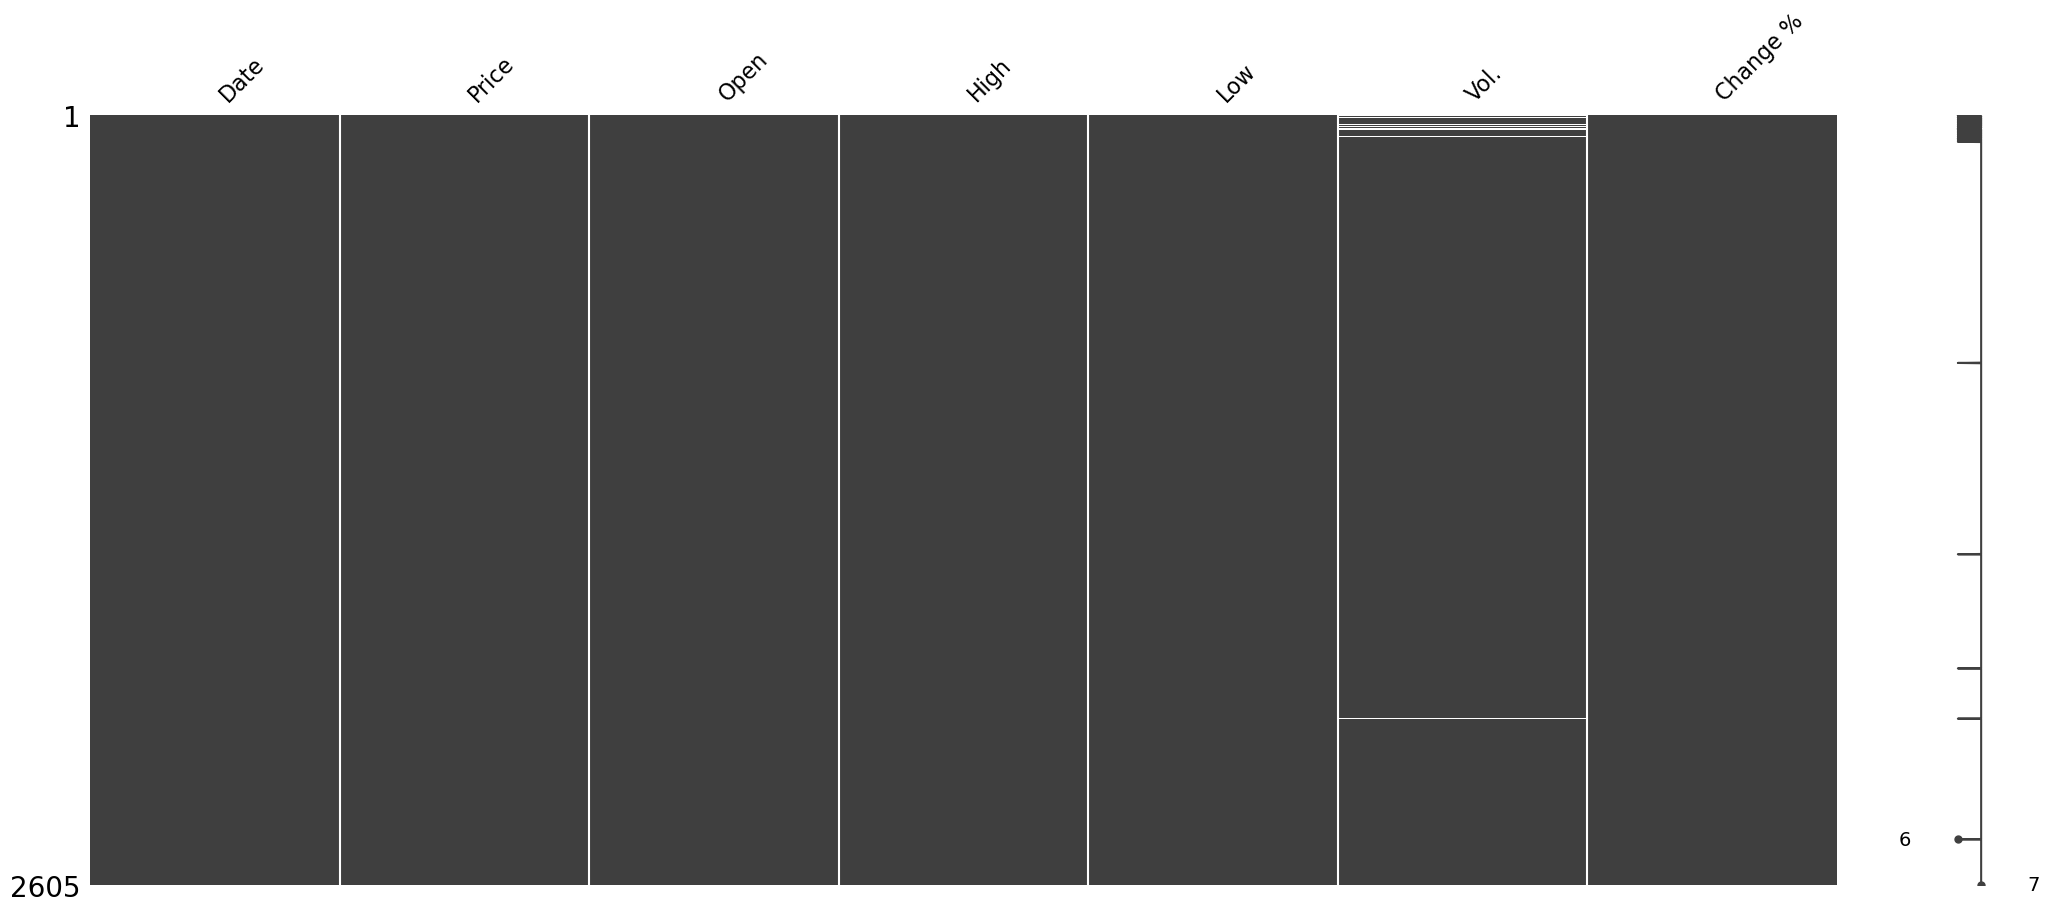

In [574]:
msno.matrix(silver)

<AxesSubplot: >

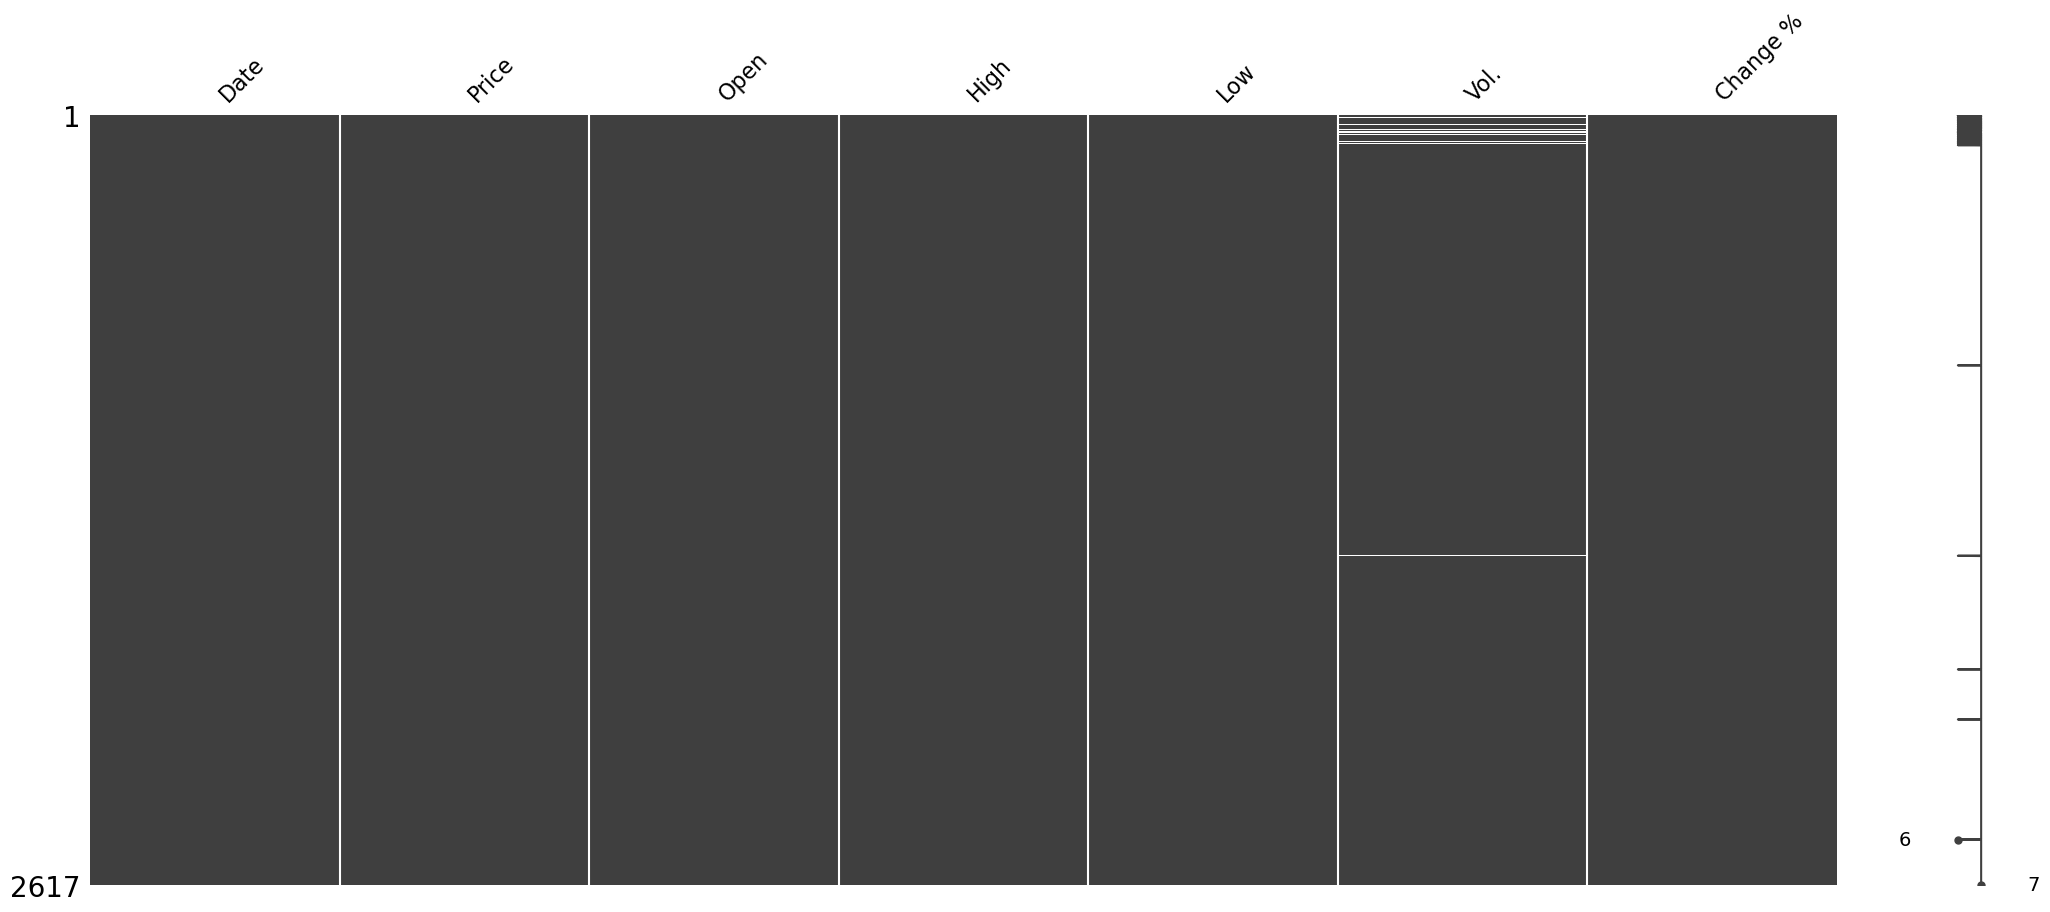

In [575]:
msno.matrix(silver_updated)

<AxesSubplot: >

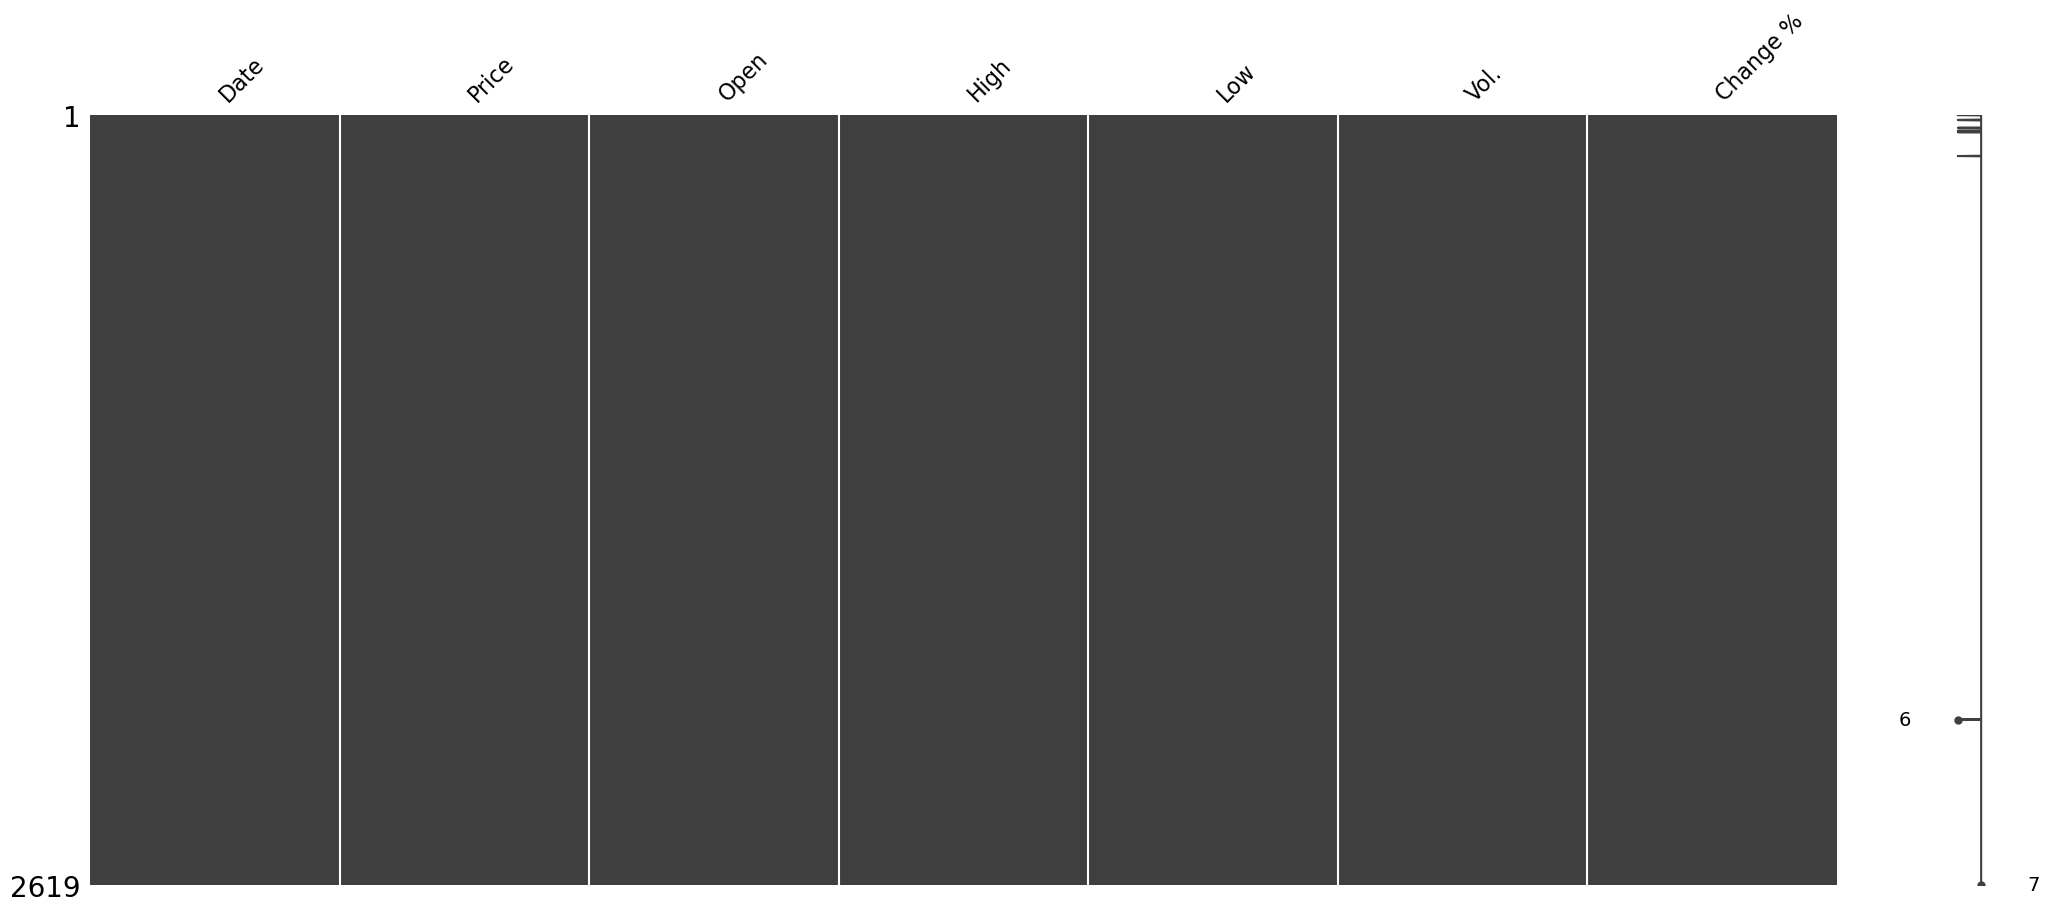

In [576]:
 msno.matrix(gold)

<AxesSubplot: >

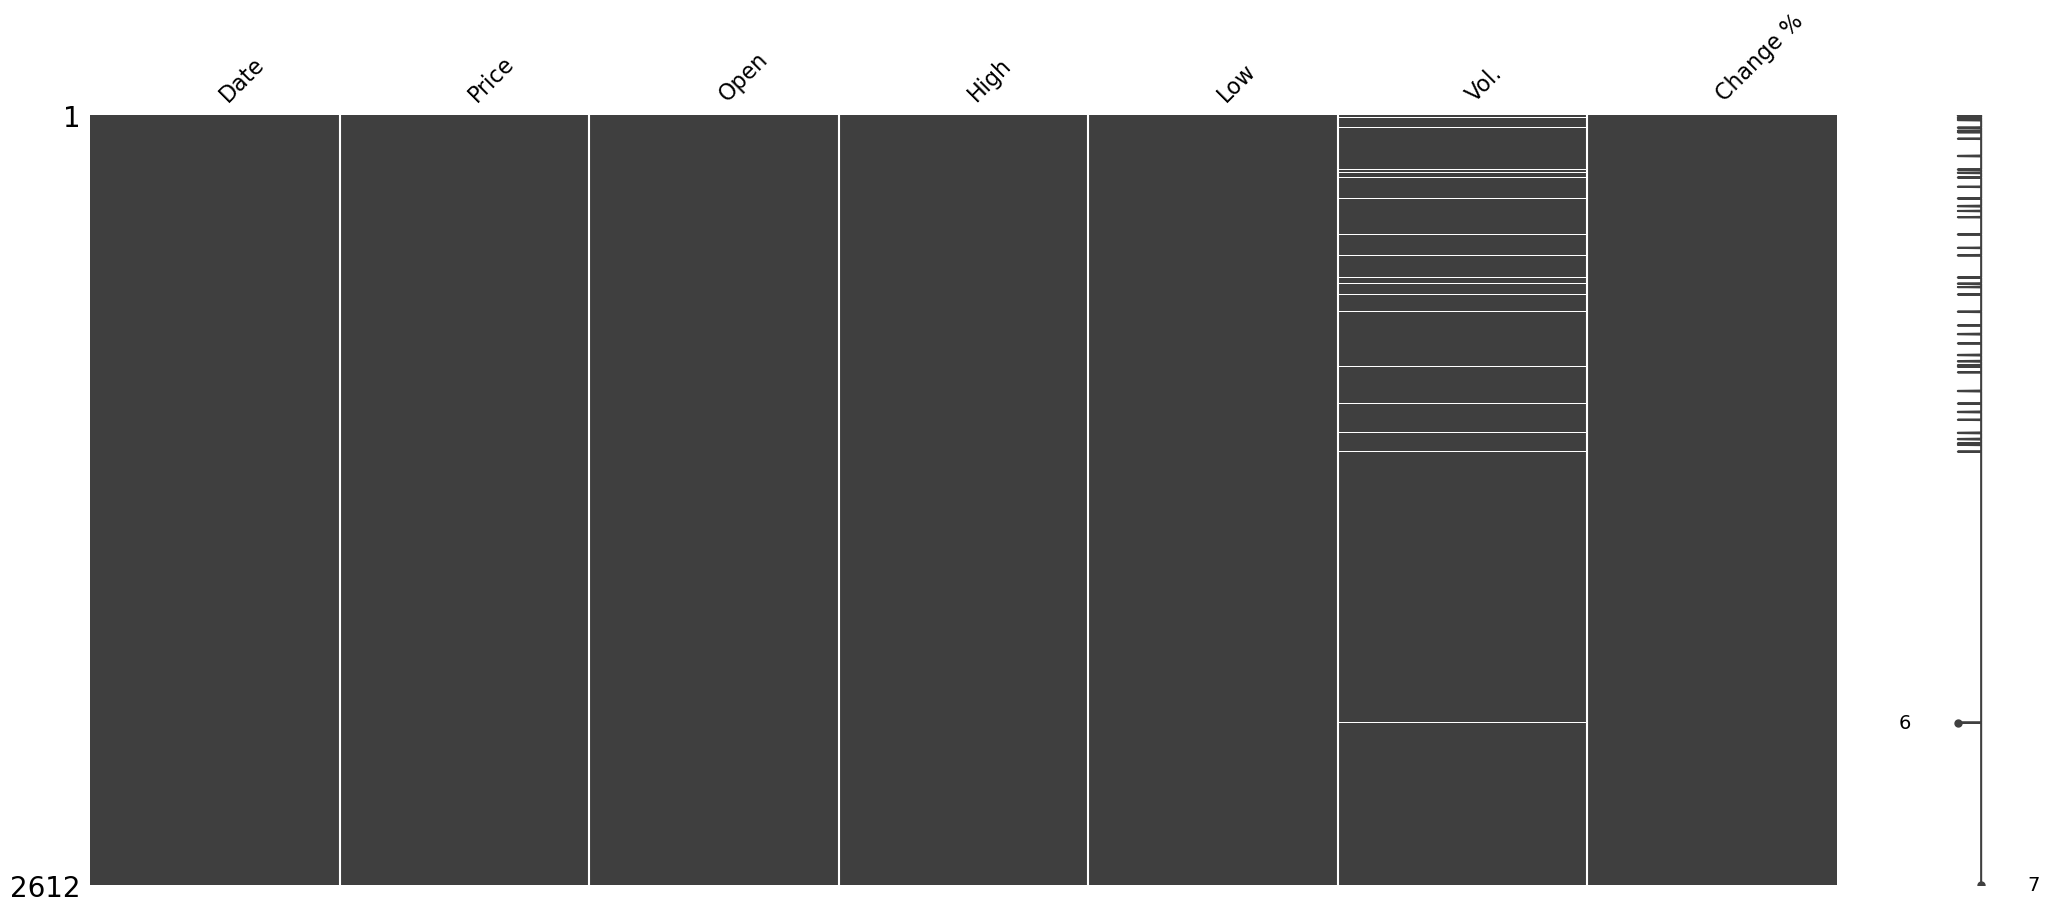

In [577]:
msno.matrix(copper)

<AxesSubplot: >

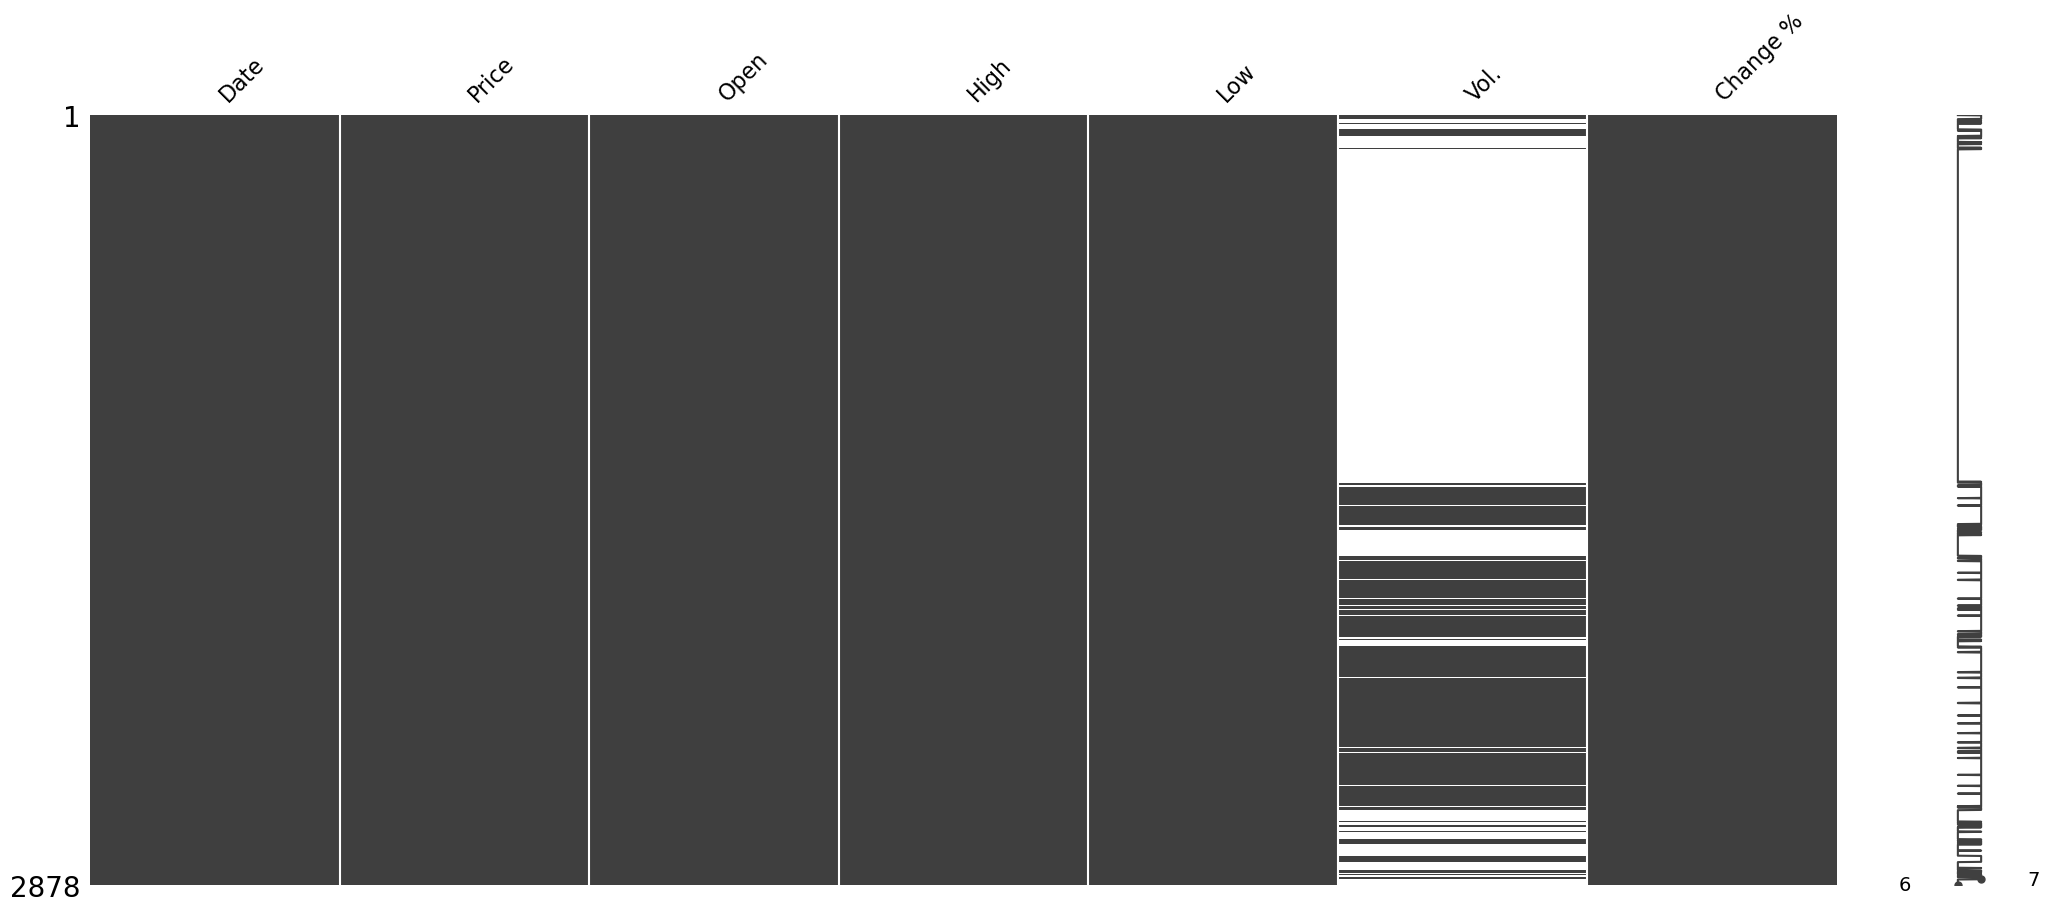

In [578]:
msno.matrix(palladium)

<AxesSubplot: >

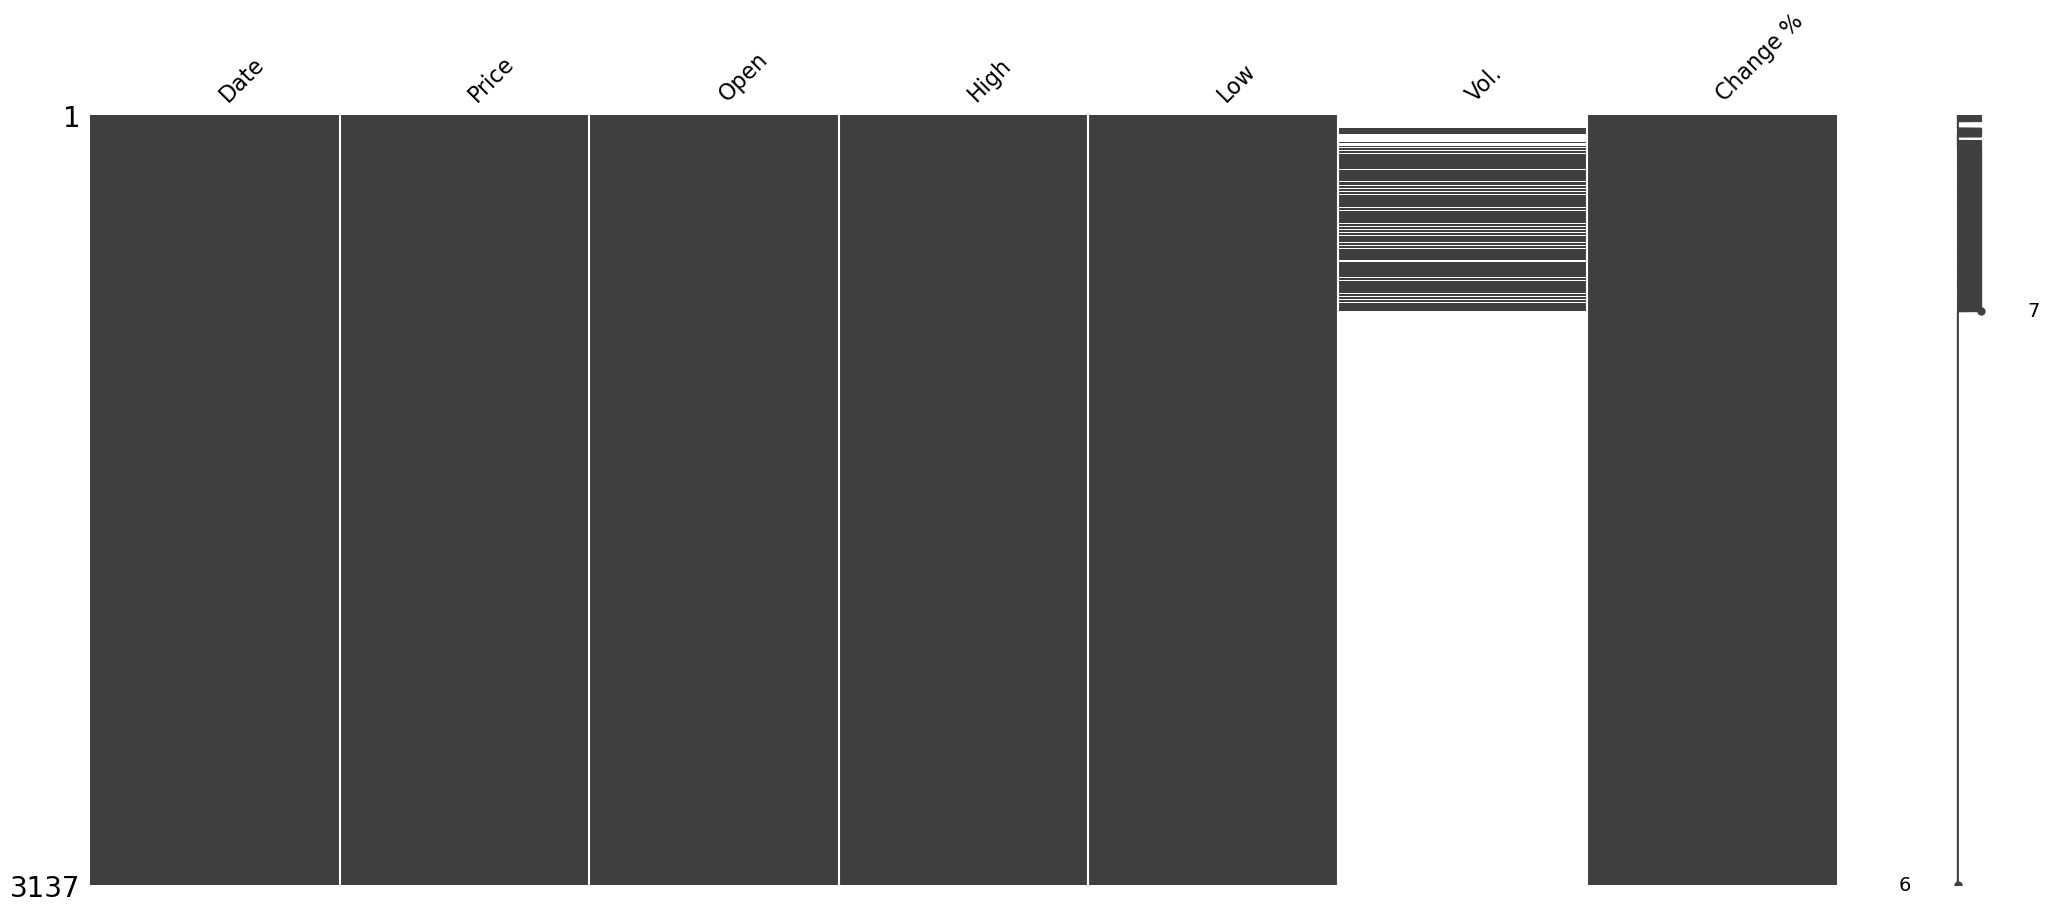

In [579]:
msno.matrix(platinum)

### Checking data types

In [580]:
silver["Date"].dtype, silver["Price"].dtype, silver["Open"].dtype, silver["High"].dtype, silver["Low"].dtype, silver["Vol."].dtype, silver["Change %"].dtype

(dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('O'))

In [581]:
silver_updated["Date"].dtype, silver_updated["Price"].dtype, silver_updated["Open"].dtype, silver_updated["High"].dtype, silver_updated["Low"].dtype, silver_updated["Vol."].dtype, silver_updated["Change %"].dtype

(dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('O'))

In [582]:
gold["Date"].dtype, gold["Price"].dtype, gold["Open"].dtype, gold["High"].dtype, gold["Low"].dtype, gold["Vol."].dtype, gold["Change %"].dtype

(dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'))

In [583]:
copper["Date"].dtype, copper["Price"].dtype, copper["Open"].dtype, copper["High"].dtype, copper["Low"].dtype, copper["Vol."].dtype, copper["Change %"].dtype

(dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('O'))

In [584]:
palladium["Date"].dtype, palladium["Price"].dtype, palladium["Open"].dtype, palladium["High"].dtype, palladium["Low"].dtype, palladium["Vol."].dtype, palladium["Change %"].dtype

(dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'))

In [585]:
platinum["Date"].dtype, platinum["Price"].dtype, platinum["Open"].dtype, platinum["High"].dtype, platinum["Low"].dtype, platinum["Vol."].dtype, platinum["Change %"].dtype

(dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'))

### Addressing the data type problems
 * K
 * , for thousand units
 * %
 
 Data with K will be left as it is, because all is in the same format with K, excepto from the NaN values.

In [586]:
# Format values
silver["Vol."] = silver["Vol."].str.replace('K', '').astype('float')
silver["Change %"] = silver["Change %"].str.replace('%', '').astype('float')
silver_updated["Vol."] = silver_updated["Vol."].str.replace('K', '').astype('float')
silver_updated["Change %"] = silver_updated["Change %"].str.replace('%', '').astype('float')

copper["Vol."] = gold["Vol."].str.replace('K', '').astype('float')
copper["Change %"] = copper["Change %"].str.replace('%', '').astype('float')

gold["Vol."] = gold["Vol."].str.replace('K', '').astype('float')
gold["Change %"] = gold["Change %"].str.replace('%', '').astype('float')
gold["Price"] = gold["Price"].str.replace(',', '').astype('float')
gold["Open"] = gold["Open"].str.replace(',', '').astype('float')
gold["High"] = gold["High"].str.replace(',', '').astype('float')
gold["Low"] = gold["Low"].str.replace(',', '').astype('float')

In [587]:
# Format date
silver['Date'] = pd.to_datetime(silver['Date'], format='%m/%d/%Y')
silver_updated['Date'] = pd.to_datetime(silver_updated['Date'], format='%m/%d/%Y')

gold['Date'] = pd.to_datetime(gold['Date'], format='%m/%d/%Y')
copper['Date'] = pd.to_datetime(copper['Date'], format='%m/%d/%Y')
palladium['Date'] = pd.to_datetime(palladium['Date'], format='%m/%d/%Y')
platinum['Date'] = pd.to_datetime(platinum['Date'], format='%m/%d/%Y')

In [588]:
# To check where are the missing values, 
# I must first create a new dataframe with the complete days for the given time interval
date_range = pd.date_range(
    min(silver['Date'].min(), palladium['Date'].min()), 
    max(silver['Date'].max(), palladium['Date'].max()), freq='D')
date_df = pd.DataFrame({'Date': date_range})

merged_df_silver = pd.merge(date_df, silver, how='left', on='Date')
merged_df_silver_updated = pd.merge(date_df, silver_updated, how='left', on='Date')
merged_df_gold = pd.merge(date_df, gold, how='left', on='Date')
merged_df_copper = pd.merge(date_df, copper, how='left', on='Date')
merged_df_palladium = pd.merge(date_df, palladium, how='left', on='Date')
merged_df_platinum = pd.merge(date_df, platinum, how='left', on='Date')

missing_dates_silver = merged_df_silver[merged_df_silver['Price'].isnull()]
missing_dates_gold = merged_df_gold[merged_df_gold['Price'].isnull()]
missing_dates_copper = merged_df_copper[merged_df_copper['Price'].isnull()]
missing_dates_palladium = merged_df_palladium[merged_df_palladium['Price'].isnull()]
missing_dates_platinum = merged_df_platinum[merged_df_platinum['Price'].isnull()]

print("Missing values of silver")
print(len(missing_dates_silver))
print("Missing values of gold")
print(len(missing_dates_gold))
print("Missing values of copper")
print(len(missing_dates_copper))
print("Missing values of palladium")
print(len(missing_dates_palladium))
print("Missing values of platinum")
print(len(missing_dates_platinum))

Missing values of silver
1093
Missing values of gold
1079
Missing values of copper
1086
Missing values of palladium
820
Missing values of platinum
561


<AxesSubplot: title={'center': 'Silver Price with missing days'}>

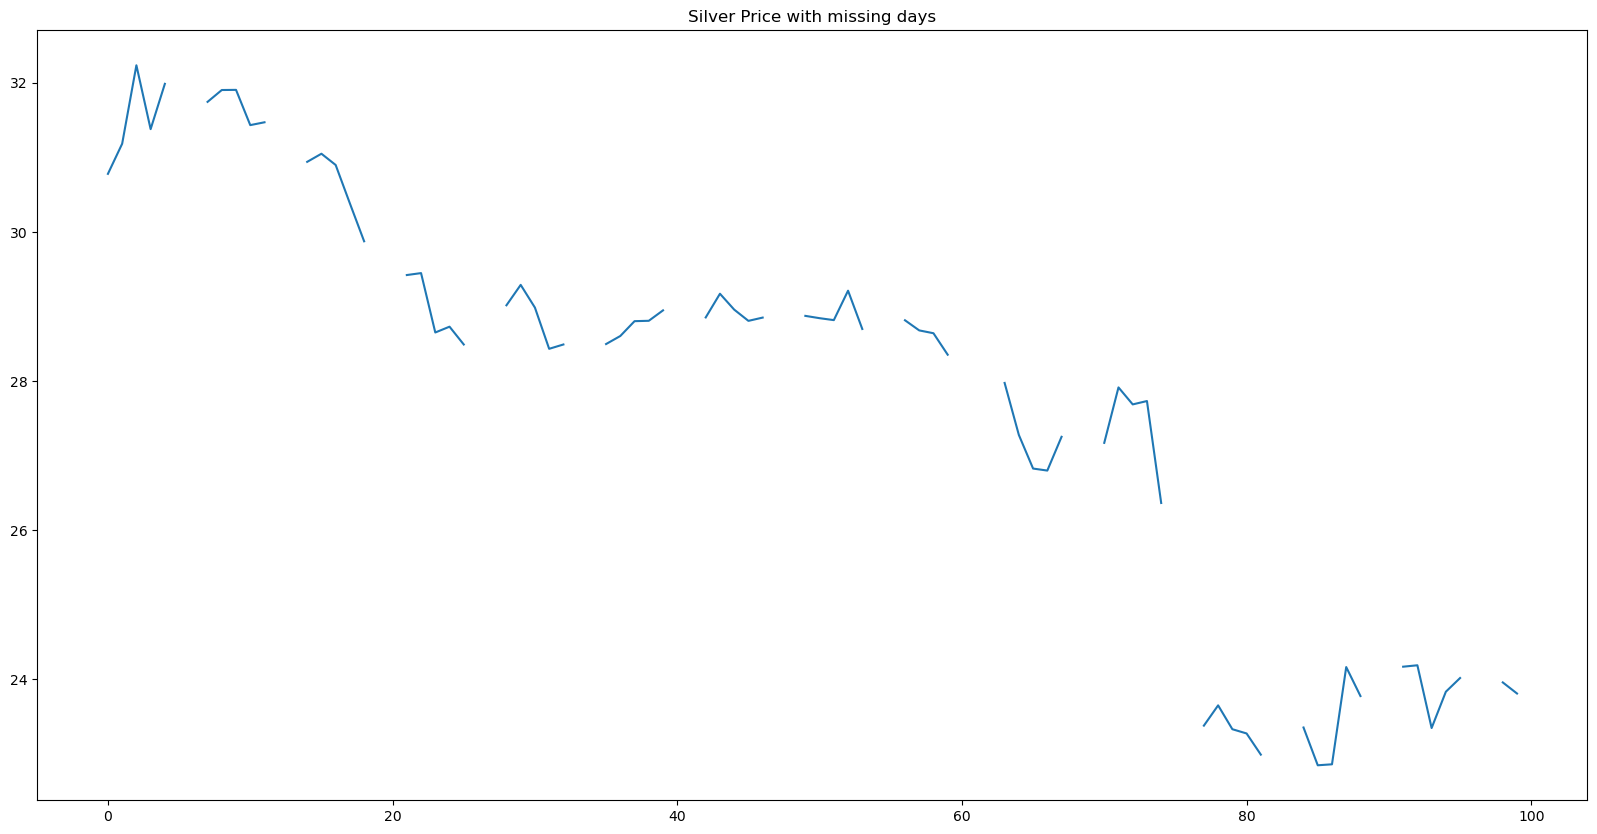

In [589]:
# Now we can see that the missing data is way more that we expected
# The model I want to make is designed to work by a daily base, so it's easier to keep track and fix
# So we need to fill the gaps
# But this can be fixed by using data imputation techniques
merged_df_silver["Price"][:100].plot(title="Silver Price with missing days", figsize=(20,10))

* But what are these missing values? They seem to be continuous, and probably is because markets close on Saturday.
* And also, even though data was obtained in the same time range, there are different quantities of missing data, so probably there is even more reasons to that, so we can't be 100% sure.
* So the best would be trying to complete the missing parts based on the previous and future values.

# Data imputation

Source: https://github.com/Idilismiguzel/data_analysis/blob/main/missing_data/Missing_Value_Imputation.ipynb

### Fillna is a method which can fill the missing data points
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html

There are different type of fill types
* bfill: use next valid observation to fill gap
* ffill: propagate last valid observation forward to next valid backfill

<AxesSubplot: title={'center': 'Silver Price with missing days'}>

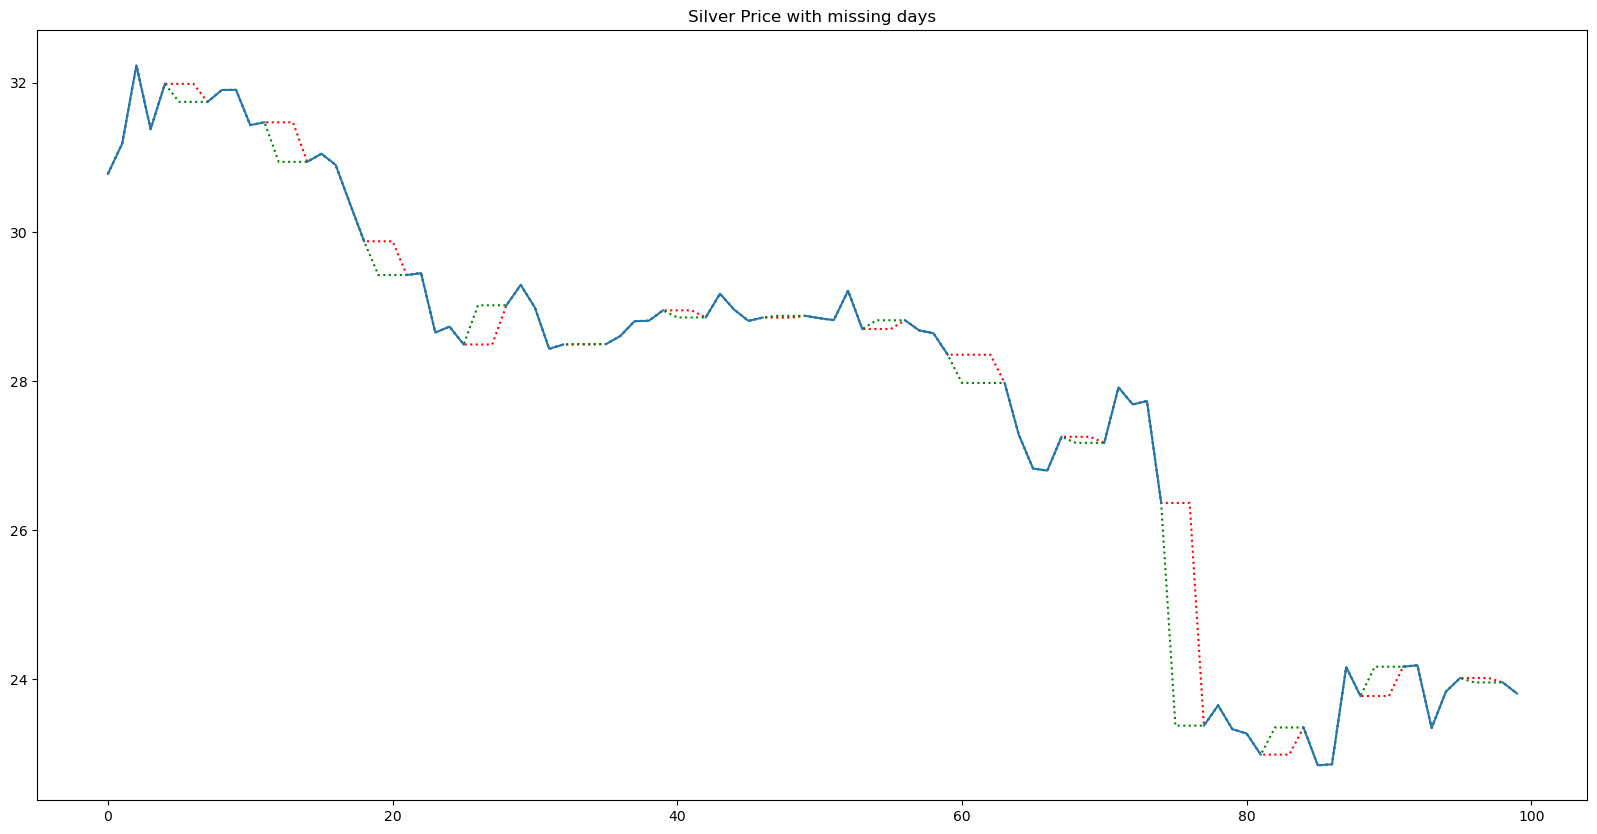

In [590]:
merged_df_silver_imp = merged_df_silver["Price"].fillna(method="ffill")
merged_df_silver_imp_2 = merged_df_silver["Price"].fillna(method="bfill")

merged_df_silver_imp[:100].plot(color="red", linestyle="dotted", figsize=(20,10))
merged_df_silver_imp_2[:100].plot(color="green", linestyle="dotted", figsize=(20,10))
merged_df_silver["Price"][:100].plot(title="Silver Price with missing days", figsize=(20,10))

<AxesSubplot: title={'center': 'Silver Price with missing days'}>

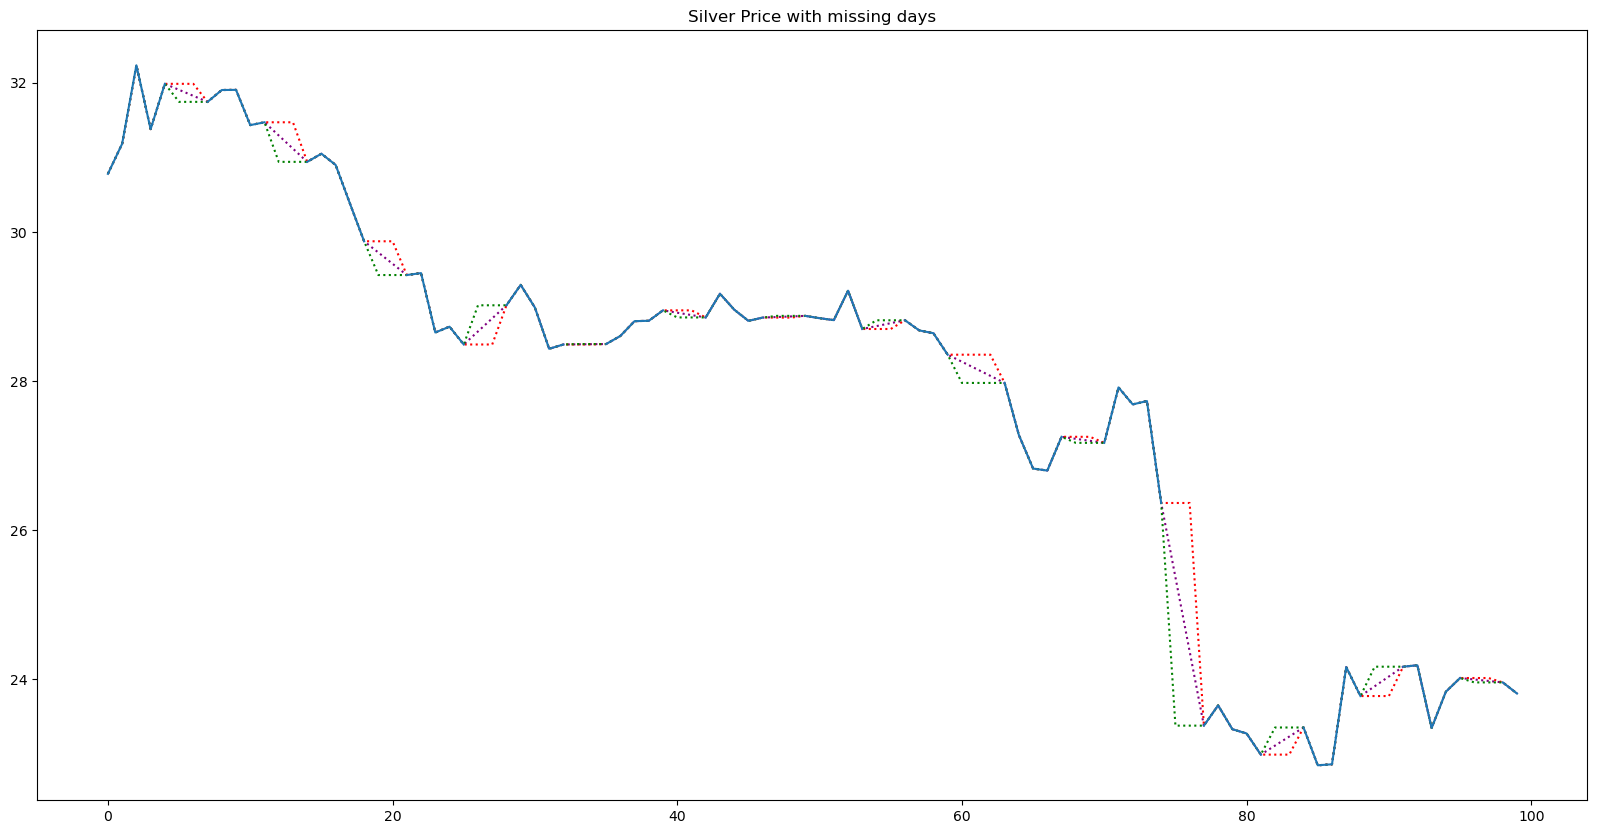

In [591]:
# The problem with this is that in this scenario, one is too optimistic and the other is too pessimistic
# So I would prefer a middle ground
merged_df_silver_linear = merged_df_silver["Price"].interpolate(method="linear")
merged_df_silver_updated_linear = merged_df_silver_updated["Price"].interpolate(method="linear")

merged_df_silver_linear[:100].plot(color="purple", linestyle="dotted", figsize=(20,10))
merged_df_silver_imp[:100].plot(color="red", linestyle="dotted", figsize=(20,10))
merged_df_silver_imp_2[:100].plot(color="green", linestyle="dotted", figsize=(20,10))
merged_df_silver["Price"][:100].plot(title="Silver Price with missing days", figsize=(20,10))

<AxesSubplot: title={'center': 'Completed Silver Price'}>

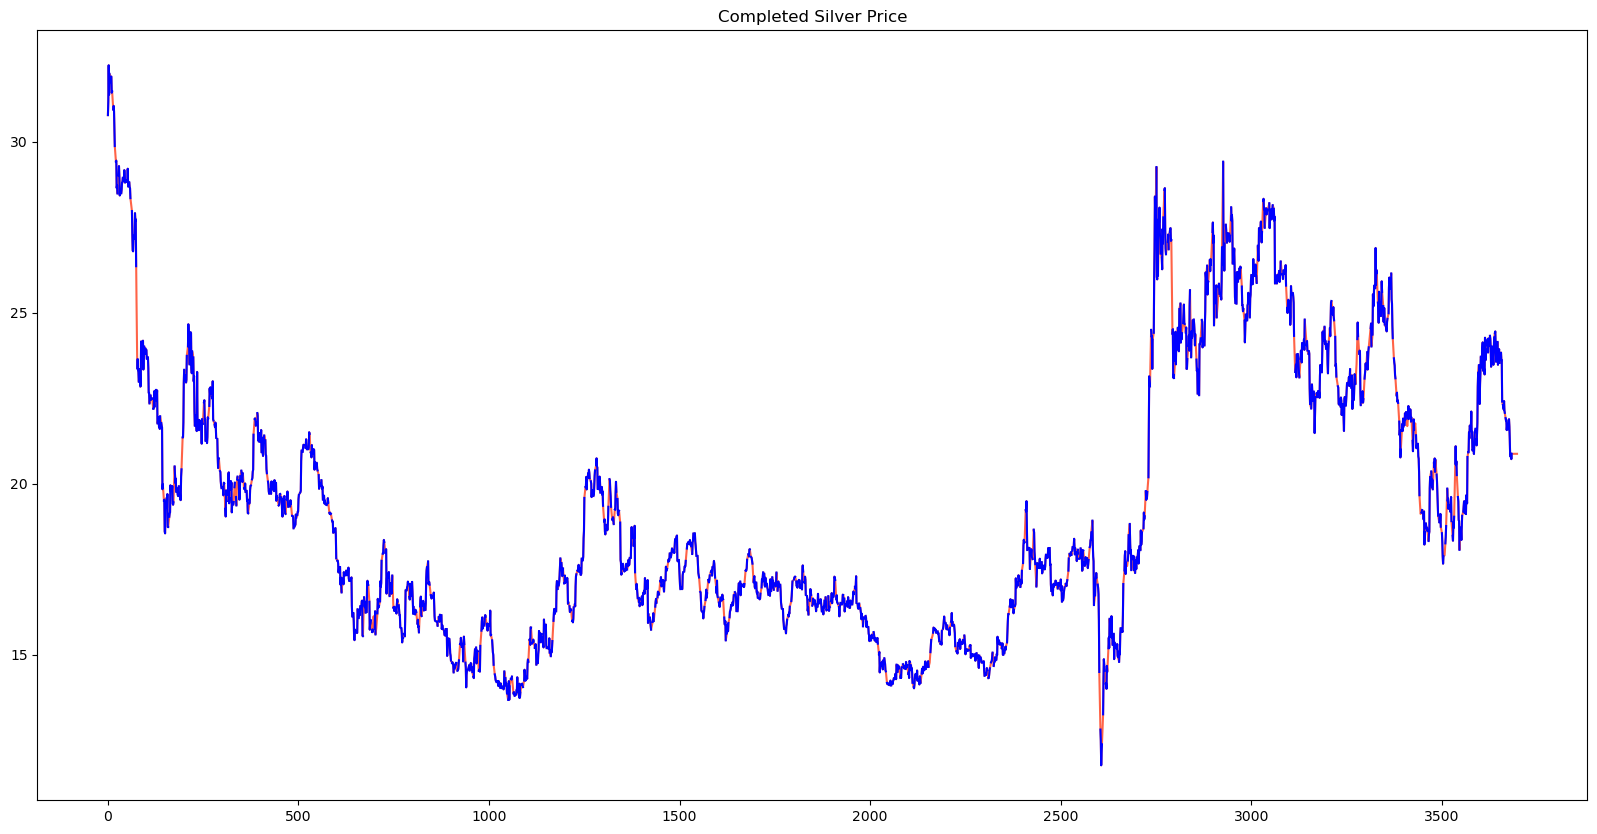

In [592]:
# New dataset (tomato) vs Old (blue)
merged_df_silver_linear.plot(title="Completed Silver Price", figsize=(20,10), color="tomato")
merged_df_silver["Price"].plot(figsize=(20,10), color="blue")

In [593]:
# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(merged_df_silver_linear.values.reshape(-1,1))

scaled_data_updated = scaler.fit_transform(merged_df_silver_updated_linear.values.reshape(-1,1))
scaled_data, scaled_data_updated

(array([[ 0.85761055],
        [ 0.8970926 ],
        [ 1.        ],
        ...,
        [-0.1100904 ],
        [-0.1100904 ],
        [-0.1100904 ]]),
 array([[ 0.85761055],
        [ 0.8970926 ],
        [ 1.        ],
        ...,
        [-0.12602003],
        [-0.02066944],
        [-0.01978989]]))

# Shaping Data

* **Time series problem**: how to predict something based on time order. We cannot just simply make a range of 0 to n, indexing every data point, because, when we train the model, we'll use the time to train the model and to predict we will use the price data. If the data is just a simple 0 to n, it will just mean that our training data is a straight line. So we have to make a function that actually relates both the date and the data. In short we want a model that we input a future date, and we output the predicted price for that specific date, or prices for a set of dates.


In [594]:
# https://www.crosstab.io/articles/time-series-pytorch-lstm/
class SilverDataset(Dataset):
    def __init__(self, data, target):
        self.X = torch.tensor(data).float()
        self.y = torch.tensor(target).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx,:,:], self.y[idx,:]

In [595]:
#https://github.com/RodolfoLSS/stock-prediction-pytorch/blob/master/stock-prediction-pytorch.ipynb
#https://machinelearningmastery.com/training-a-pytorch-model-with-dataloader-and-dataset/

# This method takes the n-1 values from data to make X with n = lookback, and the value number n to make the target y
# So that basically uses [0, n-1] values with the target value at pos [n]
def split_data(data_raw, lookback, split):
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback + 1): # I Modified this part to generate the last piece of data missing
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round((1-split)*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [596]:
def batch_data(data_raw, lookback):
    data = []
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback + 1): # I Modified this part to generate the last piece of data missing
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    
    x_ = data[:,:-1,:]
    y_ = data[:,-1,:]
    
    return [x_,y_]

In [597]:
seq_length=30 # Sequence of data of previous X to train per each target value y
split=0.8

In [598]:
x_silver_data, y_silver_data = batch_data(scaled_data, seq_length)
x_silver_updated_data, y_silver_updated_data = batch_data(scaled_data_updated, seq_length)
x_silver_train, y_silver_train, x_silver_test, y_silver_test = split_data(scaled_data, seq_length, split)
print('x_train.shape = ',x_silver_train.shape)
print('y_train.shape = ',y_silver_train.shape)
print('x_test.shape = ',x_silver_test.shape)
print('y_test.shape = ',y_silver_test.shape)
print('X_full.shape = ', x_silver_data.shape)
print('y_full.shape = ', y_silver_data.shape)
print('X_full.shape = ', x_silver_updated_data.shape)
print('y_full.shape = ', y_silver_updated_data.shape)

x_train.shape =  (2935, 29, 1)
y_train.shape =  (2935, 1)
x_test.shape =  (734, 29, 1)
y_test.shape =  (734, 1)
X_full.shape =  (3669, 29, 1)
y_full.shape =  (3669, 1)
X_full.shape =  (3669, 29, 1)
y_full.shape =  (3669, 1)


In [599]:
dataset = SilverDataset(x_silver_data, y_silver_data)
len(dataset)

3669

In [600]:
train_len = int(len(dataset)*split)
lens = [train_len, len(dataset)-train_len]
train_ds, test_ds = random_split(dataset, lens)
trainloader = DataLoader(train_ds, batch_size=seq_length, shuffle=True, drop_last=True)
testloader = DataLoader(test_ds, batch_size=seq_length, shuffle=True, drop_last=True)
trainloader, testloader

(<torch.utils.data.dataloader.DataLoader at 0x7fdb11e104f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fdb11e10520>)

In [601]:
for x, y in trainloader:
    print(x, y)


tensor([[[-0.4881],
         [-0.4777],
         [-0.4711],
         [-0.4620],
         [-0.4529],
         [-0.4438],
         [-0.4088],
         [-0.4022],
         [-0.3957],
         [-0.4011],
         [-0.3978],
         [-0.3945],
         [-0.3913],
         [-0.3991],
         [-0.3930],
         [-0.3869],
         [-0.3766],
         [-0.3757],
         [-0.3748],
         [-0.3739],
         [-0.3529],
         [-0.3750],
         [-0.3976],
         [-0.3811],
         [-0.3846],
         [-0.3882],
         [-0.3917],
         [-0.4166],
         [-0.3925]],

        [[-0.3240],
         [-0.2872],
         [-0.2832],
         [-0.2792],
         [-0.2752],
         [-0.2595],
         [-0.2461],
         [-0.2453],
         [-0.2793],
         [-0.2802],
         [-0.2811],
         [-0.2820],
         [-0.2284],
         [-0.2356],
         [-0.2516],
         [-0.1193],
         [-0.1127],
         [-0.1061],
         [-0.1061],
         [-0.0491],
         [-0.0662]

tensor([[[-0.4564],
         [-0.4434],
         [-0.4450],
         [-0.4431],
         [-0.4362],
         [-0.4128],
         [-0.4075],
         [-0.4023],
         [-0.3971],
         [-0.4005],
         [-0.4036],
         [-0.3835],
         [-0.3828],
         [-0.3900],
         [-0.3972],
         [-0.4044],
         [-0.4055],
         [-0.4078],
         [-0.4153],
         [-0.4239],
         [-0.4416],
         [-0.4593],
         [-0.4770],
         [-0.4649],
         [-0.4597],
         [-0.4905],
         [-0.4939],
         [-0.4886],
         [-0.4833]],

        [[-0.5022],
         [-0.4891],
         [-0.4760],
         [-0.4629],
         [-0.4917],
         [-0.4724],
         [-0.4884],
         [-0.4986],
         [-0.4928],
         [-0.4871],
         [-0.4814],
         [-0.4788],
         [-0.4888],
         [-0.4789],
         [-0.4494],
         [-0.4667],
         [-0.4841],
         [-0.5014],
         [-0.4897],
         [-0.4749],
         [-0.4899]

         [-0.6114]]]) tensor([[-0.7587],
        [-0.4101],
        [-0.4302],
        [ 0.2704],
        [-0.5714],
        [-0.4529],
        [-0.5734],
        [ 0.3676],
        [-0.4479],
        [-0.6861],
        [-0.5512],
        [-0.6087],
        [-0.7036],
        [-0.2175],
        [-0.2645],
        [ 0.1139],
        [-0.7977],
        [-0.5776],
        [-0.7127],
        [ 0.1755],
        [ 0.5137],
        [-0.6987],
        [-0.6443],
        [-0.0437],
        [-0.4150],
        [-0.4638],
        [-0.2394],
        [-0.5426],
        [-0.2779],
        [-0.6230]])
tensor([[[-0.1555],
         [-0.1644],
         [-0.1798],
         [-0.1827],
         [-0.1856],
         [-0.1886],
         [-0.1952],
         [-0.2337],
         [-0.2140],
         [-0.2263],
         [-0.2277],
         [-0.2290],
         [-0.2304],
         [-0.2269],
         [-0.1964],
         [-0.1726],
         [-0.1575],
         [-0.1526],
         [-0.1477],
         [-0.1427],
       

tensor([[[-0.4128],
         [-0.4075],
         [-0.4023],
         [-0.3971],
         [-0.4005],
         [-0.4036],
         [-0.3835],
         [-0.3828],
         [-0.3900],
         [-0.3972],
         [-0.4044],
         [-0.4055],
         [-0.4078],
         [-0.4153],
         [-0.4239],
         [-0.4416],
         [-0.4593],
         [-0.4770],
         [-0.4649],
         [-0.4597],
         [-0.4905],
         [-0.4939],
         [-0.4886],
         [-0.4833],
         [-0.4780],
         [-0.5038],
         [-0.5093],
         [-0.5040],
         [-0.5207]],

        [[-0.4914],
         [-0.4916],
         [-0.4870],
         [-0.4824],
         [-0.4777],
         [-0.4863],
         [-0.4572],
         [-0.4643],
         [-0.4732],
         [-0.4790],
         [-0.4848],
         [-0.4905],
         [-0.4701],
         [-0.4698],
         [-0.4807],
         [-0.4443],
         [-0.4369],
         [-0.4295],
         [-0.4221],
         [-0.3719],
         [-0.3558]

tensor([[[-0.0817],
         [-0.1171],
         [-0.1238],
         [-0.1615],
         [-0.2284],
         [-0.2462],
         [-0.2640],
         [-0.2818],
         [-0.2799],
         [-0.2781],
         [-0.2753],
         [-0.2706],
         [-0.2739],
         [-0.2773],
         [-0.2807],
         [-0.2977],
         [-0.2747],
         [-0.3694],
         [-0.3333],
         [-0.3253],
         [-0.3173],
         [-0.3093],
         [-0.3217],
         [-0.3261],
         [-0.3211],
         [-0.3311],
         [-0.3405],
         [-0.3499],
         [-0.3593]],

        [[ 0.2346],
         [ 0.2441],
         [ 0.2537],
         [ 0.2632],
         [ 0.2908],
         [ 0.3163],
         [ 0.2643],
         [ 0.2610],
         [ 0.2527],
         [ 0.2444],
         [ 0.2361],
         [ 0.2507],
         [ 0.1324],
         [ 0.1325],
         [ 0.1604],
         [ 0.1730],
         [ 0.1856],
         [ 0.1982],
         [ 0.2277],
         [ 0.1846],
         [ 0.3114]

tensor([[[-7.1248e-01],
         [-7.0584e-01],
         [-6.9919e-01],
         [-6.9255e-01],
         [-7.0838e-01],
         [-6.8238e-01],
         [-6.7027e-01],
         [-6.1671e-01],
         [-6.1870e-01],
         [-6.2069e-01],
         [-6.2267e-01],
         [-6.4642e-01],
         [-6.4877e-01],
         [-6.3088e-01],
         [-6.2541e-01],
         [-6.2815e-01],
         [-6.3088e-01],
         [-6.3362e-01],
         [-6.5903e-01],
         [-6.6313e-01],
         [-5.8358e-01],
         [-6.0528e-01],
         [-6.0410e-01],
         [-6.0293e-01],
         [-6.0176e-01],
         [-5.9805e-01],
         [-6.5795e-01],
         [-6.6509e-01],
         [-6.6531e-01]],

        [[ 6.7548e-01],
         [ 6.7238e-01],
         [ 6.6929e-01],
         [ 7.0037e-01],
         [ 6.7955e-01],
         [ 6.6479e-01],
         [ 6.6909e-01],
         [ 6.6984e-01],
         [ 6.7059e-01],
         [ 6.7134e-01],
         [ 6.6831e-01],
         [ 6.6577e-01],
         [ 7.0

tensor([[[-0.3093],
         [-0.3217],
         [-0.3261],
         [-0.3211],
         [-0.3311],
         [-0.3405],
         [-0.3499],
         [-0.3593],
         [-0.3391],
         [-0.3327],
         [-0.2088],
         [-0.1766],
         [-0.1713],
         [-0.1659],
         [-0.1605],
         [-0.1823],
         [-0.2063],
         [-0.1840],
         [-0.2113],
         [-0.1862],
         [-0.1610],
         [-0.1359],
         [-0.1488],
         [-0.1234],
         [-0.1618],
         [-0.1277],
         [-0.1416],
         [-0.1554],
         [-0.1693]],

        [[-0.3889],
         [-0.3963],
         [-0.3630],
         [-0.3585],
         [-0.3380],
         [-0.3379],
         [-0.3378],
         [-0.3377],
         [-0.3376],
         [-0.3613],
         [-0.3720],
         [-0.3861],
         [-0.4018],
         [-0.4018],
         [-0.4019],
         [-0.4019],
         [-0.4281],
         [-0.4502],
         [-0.4564],
         [-0.4635],
         [-0.4772]

- The test data has the last 20% of the data, and the y array has the target values.
- Here we can see the comparison with the original data and the last values of y
- The difference is we filled with values for the 25 of feb

In [602]:
silver.head(), print(scaler.inverse_transform(y_silver_test[:-1][-4:]))

[[20.878]
 [20.878]
 [20.878]
 [20.878]]


(        Date   Price    Open    High     Low   Vol.  Change %
 0 2023-02-28  20.878  20.723  20.942  20.508    NaN      0.75
 1 2023-02-27  20.723  20.872  20.930  20.642    NaN     -0.73
 2 2023-02-26  20.875  20.855  20.942  20.850    NaN      0.31
 3 2023-02-24  20.810  21.330  21.395  20.725  51.63     -2.33
 4 2023-02-23  21.306  21.520  21.670  21.260  52.99     -1.71,
 None)

# GRU (gated recurrent unit) & LSTM (long short term memory)
- GRUs or LSTMs (long short term memory) have been used to solve time series problems.
- GRU: 

https://pytorch.org/docs/stable/generated/torch.nn.GRU.html?highlight=gru#torch.nn.GRU

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM

https://arxiv.org/pdf/1412.3555.pdf
- LSTM: 

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [603]:
x_silver_train = torch.from_numpy(x_silver_train).type(torch.Tensor)
x_silver_test = torch.from_numpy(x_silver_test).type(torch.Tensor)

y_silver_train_lstm = torch.from_numpy(y_silver_train).type(torch.Tensor)
y_silver_test_lstm = torch.from_numpy(y_silver_test).type(torch.Tensor)

y_silver_train_gru = torch.from_numpy(y_silver_train).type(torch.Tensor)
y_silver_test_gru = torch.from_numpy(y_silver_test).type(torch.Tensor)

### FULL
x_silver_data = torch.from_numpy(x_silver_data).type(torch.Tensor)
y_silver_data = torch.from_numpy(y_silver_data).type(torch.Tensor)

In [604]:
#Setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define hyperparameters
input_size = 1
num_layers= 8
hidden_size = 32
output_size = 1
num_epochs = 100 # The model learns fast enough
learning_rate = 0.001

print(device)

cuda


In [605]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [606]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob=0.2):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout_prob)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [607]:
silver_model_gru = GRU(input_size, hidden_size, num_layers, output_size)
silver_model_gru

GRU(
  (gru): GRU(1, 32, num_layers=8, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [608]:
silver_model_lstm = LSTM(input_size, hidden_size, num_layers, output_size)
silver_model_lstm

LSTM(
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(1, 32, num_layers=8, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [609]:
# Setup loss function and optimizer
loss_fn = nn.MSELoss(reduction='mean').to(device)
optimizer_gru = torch.optim.Adam(silver_model_gru.parameters(), 
                             lr=learning_rate)
optimizer_lstm = torch.optim.Adam(silver_model_lstm.parameters(), 
                             lr=learning_rate)

In [610]:
# Training LSTM
hist = np.zeros(num_epochs)
hist_test = np.zeros(num_epochs)

start_time = time.time()

silver_model_lstm.to(device)

for epoch in range(num_epochs):
    #Train
    silver_model_lstm.train()
    
    for x, y in trainloader:
        x = x.to(device)
        y = y.to(device)
        
        # Forward pass
        y_train_pred_lstm = silver_model_lstm(x)

        # Calculate the loss
        loss = loss_fn(y_train_pred_lstm, y)
        hist[epoch] = loss.item()

        # Optimizer zero grad
        optimizer_lstm.zero_grad()

        # Loss backward
        loss.backward()

        # Step the optimizer
        optimizer_lstm.step()
    
    # Test
    silver_model_lstm.eval()

    for x, y in testloader:
        with torch.inference_mode():
            x = x.to(device)
            y = y.to(device)
            y_test_pred_lstm = silver_model_lstm(x)
            test_loss = loss_fn(y_test_pred_lstm, y)
            hist_test[epoch] = test_loss.item()

    if epoch % 10 == 0:
        print("Epoch ", epoch, 
              f"MSE: {loss.item():.5f}", 
              f"Test MSE: {test_loss.item():.5}")
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE: 0.04521 Test MSE: 0.04596
Epoch  10 MSE: 0.00451 Test MSE: 0.0012247
Epoch  20 MSE: 0.00144 Test MSE: 0.0018639
Epoch  30 MSE: 0.00057 Test MSE: 0.00041287
Epoch  40 MSE: 0.00048 Test MSE: 0.00082725
Epoch  50 MSE: 0.00090 Test MSE: 0.00089909
Epoch  60 MSE: 0.00047 Test MSE: 0.0013163
Epoch  70 MSE: 0.00076 Test MSE: 0.0004689
Epoch  80 MSE: 0.00103 Test MSE: 0.0011136
Epoch  90 MSE: 0.00101 Test MSE: 0.00046775
Training time: 44.754401206970215


In [611]:
# Inference
silver_model_lstm.eval()
with torch.no_grad():
    y_preds_lstm = silver_model_lstm(x_silver_data.to(device))

In [612]:
# Rescale data into prices
lstm_silver_preds = pd.DataFrame(scaler.inverse_transform(y_preds_lstm.cpu().detach().numpy()))
original_data = pd.DataFrame(scaler.inverse_transform(y_silver_data.numpy()))

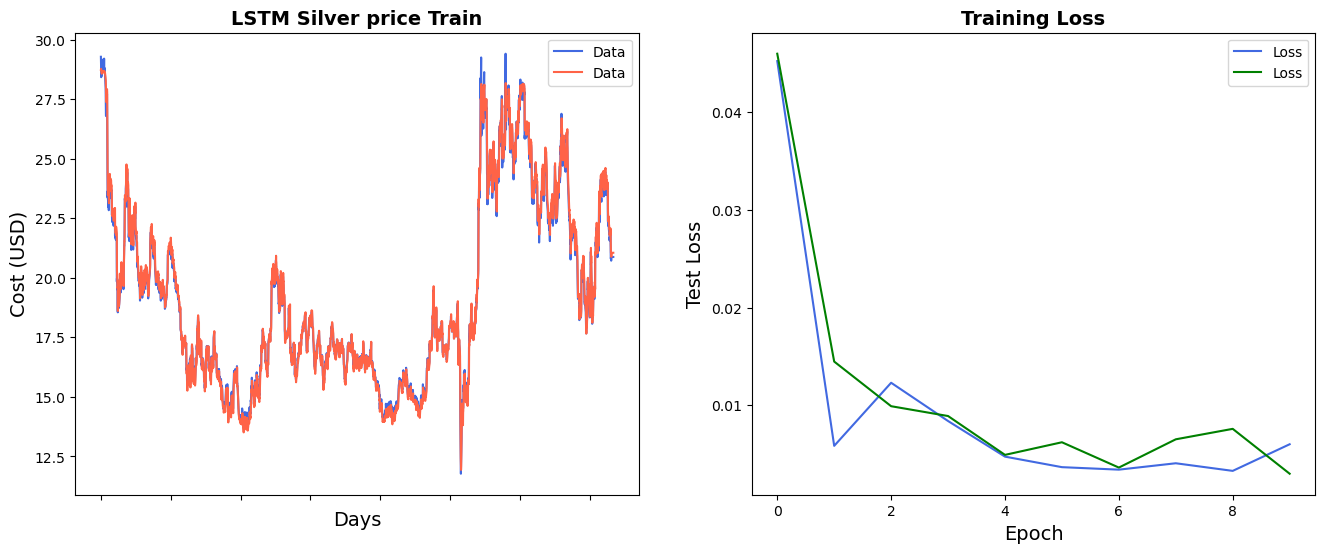

In [613]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original_data.index, y = original_data[0], label="Data", color='royalblue')
ax = sns.lineplot(x = lstm_silver_preds.index, y = lstm_silver_preds[0], label="Data", color='tomato')

ax.set_title('LSTM Silver price Train', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist[:10], label="Loss", color='royalblue')
ax = sns.lineplot(data=hist_test[:10], label="Loss", color='green')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Test Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [614]:
hist_gru = np.zeros(num_epochs)
hist_gru_test = np.zeros(num_epochs)

start_time = time.time()

silver_model_gru.to(device)

for epoch in range(num_epochs):
    #Train
    silver_model_gru.train()
    
    for x, y in trainloader:
        x = x.to(device)
        y = y.to(device)
        
        # Forward pass
        y_train_pred_gru = silver_model_gru(x)

        # Calculate the loss
        loss = loss_fn(y_train_pred_gru, y)
        hist_gru[epoch] = loss.item()

        # Optimizer zero grad
        optimizer_gru.zero_grad()

        # Loss backward
        loss.backward()

        # Step the optimizer
        optimizer_gru.step()
    
    # Test
    silver_model_gru.eval()

    for x, y in testloader:
        with torch.inference_mode():
            x = x.to(device)
            y = y.to(device)
            y_test_pred_gru = silver_model_gru(x)
            test_loss = loss_fn(y_test_pred_gru, y)
            hist_gru_test[epoch] = test_loss.item()

    if epoch % 10 == 0:
        print("Epoch ", epoch, 
              f"MSE: {loss.item():.5f}", 
              f"Test MSE: {test_loss.item():.5}")
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE: 0.00552 Test MSE: 0.0061013
Epoch  10 MSE: 0.00042 Test MSE: 0.00030745
Epoch  20 MSE: 0.00180 Test MSE: 0.0026442
Epoch  30 MSE: 0.00268 Test MSE: 0.0019773
Epoch  40 MSE: 0.00058 Test MSE: 0.0008011
Epoch  50 MSE: 0.00109 Test MSE: 0.00052506
Epoch  60 MSE: 0.00055 Test MSE: 0.00043634
Epoch  70 MSE: 0.00151 Test MSE: 0.0010806
Epoch  80 MSE: 0.00060 Test MSE: 0.00070243
Epoch  90 MSE: 0.00140 Test MSE: 0.0020518
Training time: 43.88783812522888


In [615]:
# Inference
silver_model_gru.eval()
with torch.no_grad():
    y_preds_gru = silver_model_gru(x_silver_data.to(device))
with torch.no_grad():
    y_preds_gru_train = silver_model_gru(x_silver_train.to(device))
with torch.no_grad():
    y_preds_gru_test = silver_model_gru(x_silver_test.to(device))

In [616]:
# Rescale data into prices
gru_silver_preds = pd.DataFrame(scaler.inverse_transform(y_preds_gru.cpu().detach().numpy()))
original_data = pd.DataFrame(scaler.inverse_transform(y_silver_data.numpy()))

gru_silver_preds_train = pd.DataFrame(scaler.inverse_transform(y_preds_gru_train.cpu().detach().numpy()))
original_data_train = pd.DataFrame(scaler.inverse_transform(y_silver_train_gru.numpy()))

gru_silver_preds_test = pd.DataFrame(scaler.inverse_transform(y_preds_gru_test.cpu().detach().numpy()))
original_data_test = pd.DataFrame(scaler.inverse_transform(y_silver_test_gru.numpy()))

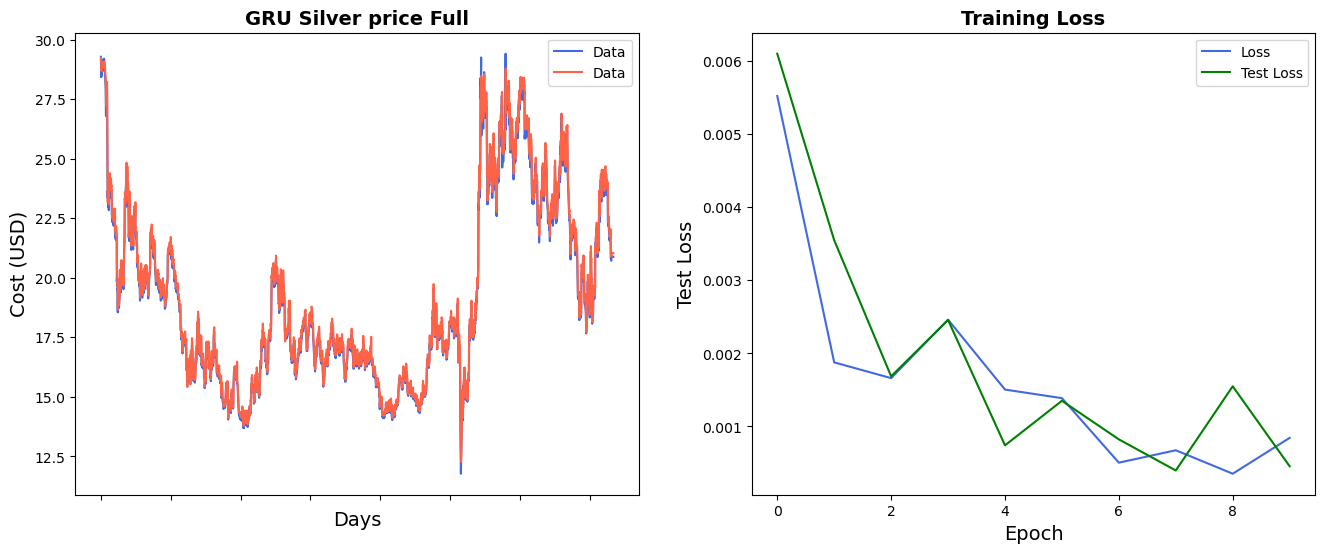

In [617]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original_data.index, y = original_data[0], label="Data", color='royalblue')
ax = sns.lineplot(x = gru_silver_preds.index, y = gru_silver_preds[0], label="Data", color='tomato')

ax.set_title('GRU Silver price Full', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist_gru[:10], label="Loss", color='royalblue')
ax = sns.lineplot(data=hist_gru_test[:10], label="Test Loss", color='green')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Test Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

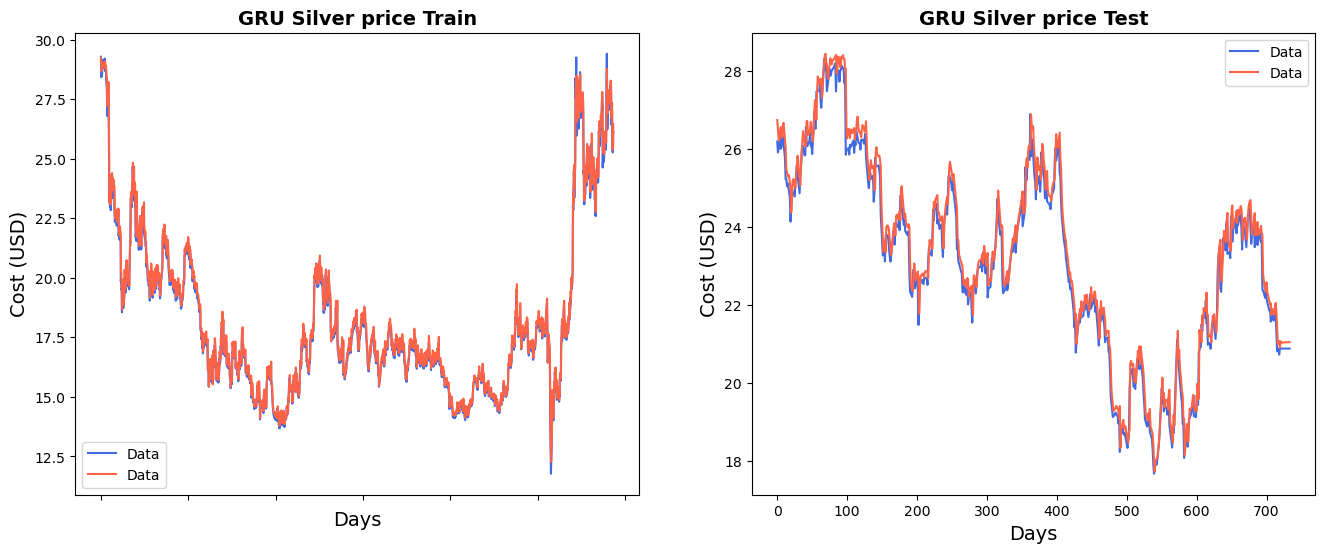

In [618]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original_data_train.index, y = original_data_train[0], label="Data", color='royalblue')
ax = sns.lineplot(x = gru_silver_preds_train.index, y = gru_silver_preds_train[0], label="Data", color='tomato')
ax.set_title('GRU Silver price Train', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(x = original_data_test.index, y = original_data_test[0], label="Data", color='royalblue')
ax = sns.lineplot(x = gru_silver_preds_test.index, y = gru_silver_preds_test[0], label="Data", color='tomato')
ax.set_title('GRU Silver price Test', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
fig.set_figheight(6)
fig.set_figwidth(16)

* So now we've proven the models are learning from the data, but we need to evaluate if the model can predict unseen data.

In [619]:
x_test = x_silver_data
days=0

In [620]:
# Evaluate prediction

# 1 Day in the future
days+=1
# Prediction based on the last 30 days
silver_model_lstm.eval()
with torch.no_grad():
  y_preds = silver_model_gru(x_test[-1:].to(device))

# Put the predicted value on top and delete the last
future = torch.cat((x_test[-1:], y_preds[-1:].unsqueeze(dim=1).cpu()), 1)
future = future[:,1:,:]
x_test = torch.cat((x_test, future), 0)

print(f"Day {days} Predicted Value: ", scaler.inverse_transform(y_preds[-1:].cpu().detach().numpy()))

Day 1 Predicted Value:  [[21.042913]]


- How to make future predictions. The plan is to predict y using the las X values from Feb 28 of 2023
- and then add the prediction on the 30 values array where I would put it as if it were the

In [621]:
# This will take the d-1 last days an produce the prediction for the dth day
# We will remove the last value of the d-1 days, and concatenate on top the dth predicted day
# And we will predict the next based on the new prediction
def futurePredictions(x_raw_data, n_preds, model):
    start_time = time.time()
    predictions = []
    x_data = x_raw_data
    
    model.eval()
    for i in range(n_preds):
        with torch.no_grad():
            y_preds = model(x_data)
        predictions.append(y_preds.item())
        x_data = torch.cat(
            (x_data[:,1:,:], # Removes oldest day from the last batch (1, d-1, 1)
             y_preds[-1:].unsqueeze(dim=1)), 1) # Inserts prediction unsqueezed (1, 1) -> (1, 1, 1)        
    training_time = time.time()-start_time
    print("Time: {}".format(training_time))
    return predictions

# Instead of using just the last batch of days, it uses a set of batches of dates
def futurePredictionsBatch(x_raw_data, n_preds, model):
    start_time = time.time()
    predictions = []
    x_data = x_raw_data
    
    model.eval()
    for i in range(n_preds):
        with torch.no_grad():
            y_preds = model(x_data)
        predictions.append(y_preds[-1:].item())
        x_data = torch.cat(
            (x_data[-1:,1:,:], # Removes oldest day from the last batch from the set of batches (1, d-1, 1)
             y_preds[-1:].unsqueeze(dim=1)), 1) # Inserts prediction unsqueezed (1, 1) -> (1, 1, 1)        
    training_time = time.time()-start_time
    print("Time: {}".format(training_time))
    return predictions

In [622]:
days_in_the_future = 30 # For predicting
window_last_data = 500 # For plotting

In [623]:
lstm_preds = futurePredictions(x_silver_data[-1:].to(device), days_in_the_future, silver_model_lstm)

Time: 0.010425329208374023


In [624]:
results_lstm = torch.tensor(np.array(lstm_preds)).float().unsqueeze(dim=1)
scaler.inverse_transform(results_lstm.detach().numpy());

In [639]:
gru_preds = futurePredictions(x_silver_data[-days_in_the_future:-(days_in_the_future-1)].to(device), days_in_the_future, silver_model_gru)
#gru_preds = futurePredictionsBatch(x_silver_data[-days_in_the_future*4:-(days_in_the_future-1)].to(device), days_in_the_future, silver_model_gru)
gru_preds_train_data = futurePredictionsBatch(x_silver_train.to(device), x_silver_test.shape[0], silver_model_gru)


Time: 0.01086735725402832
Time: 0.2620067596435547


In [640]:
results_gru = torch.tensor(np.array(gru_preds)).float().unsqueeze(dim=1)
results_gru_test = torch.tensor(np.array(gru_preds_train_data)).float().unsqueeze(dim=1)

In [641]:
target_preds = results_gru

past_data = pd.DataFrame(scaler.inverse_transform(y_silver_data.detach().numpy()))
predicted_data = pd.DataFrame(scaler.inverse_transform(target_preds))

fulld = np.concatenate((y_silver_data[:-days_in_the_future], target_preds))
full_data = pd.DataFrame(scaler.inverse_transform(fulld[-window_last_data:])) # Use last 1000 values
original = pd.DataFrame(scaler.inverse_transform(y_silver_data[-window_last_data:]))
original_updated = pd.DataFrame(scaler.inverse_transform(y_silver_updated_data[-window_last_data:]))
test_preds_gru = pd.DataFrame(scaler.inverse_transform(results_gru_test))

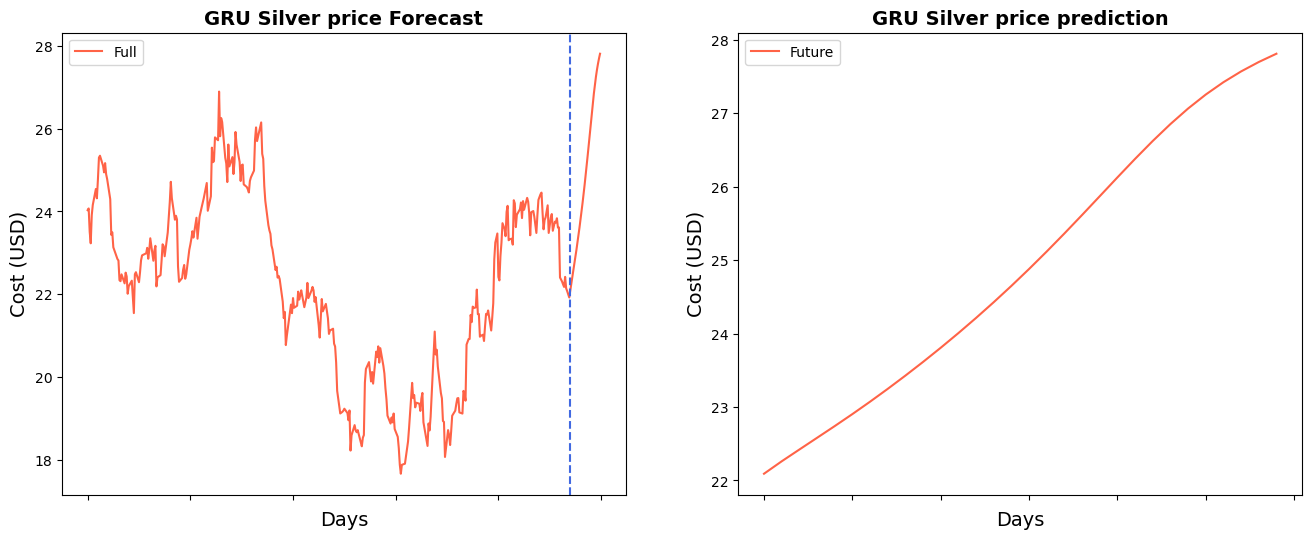

In [644]:
# The blue line separates the real data from the predicted data
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = full_data.index, y = full_data[0], label="Full", color='tomato')
ax.set_title('GRU Silver price Forecast', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10);
ax.axvline(x=window_last_data - days_in_the_future, color='royalblue', linestyle='--')

plt.subplot(1, 2, 2)
ax = sns.lineplot(x = predicted_data.index, y = predicted_data[0], label="Future", color='tomato')
ax.set_title('GRU Silver price prediction', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10);

fig.set_figheight(6)
fig.set_figwidth(16)

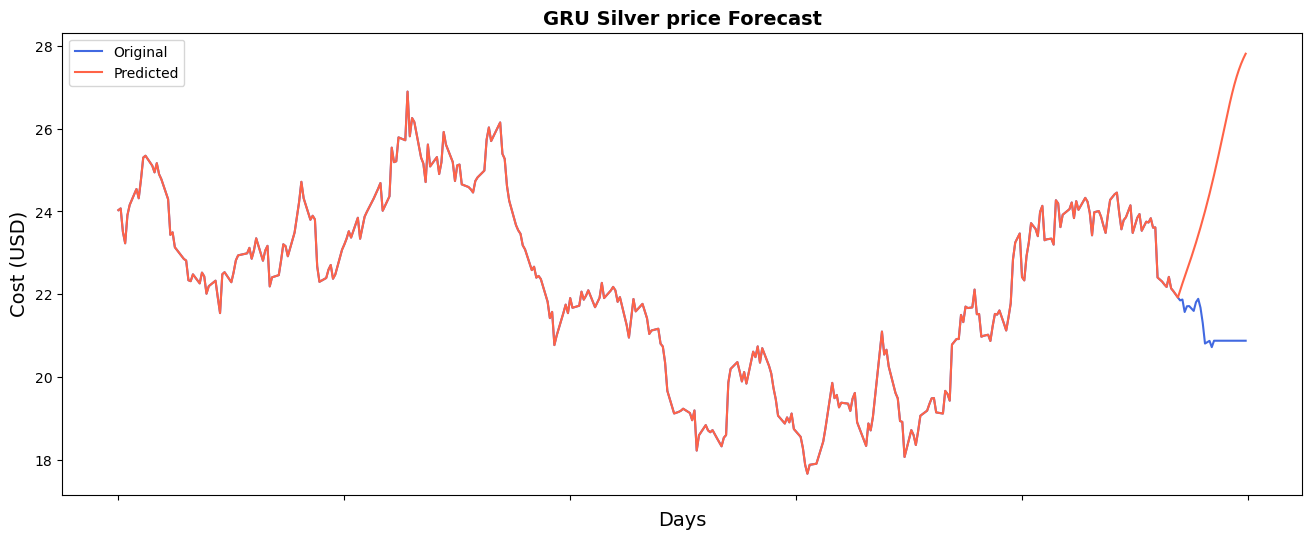

In [645]:
# Here we can see an example of the prediction of the last n days if we started predicting 1 month before the training data
# If we input the data from 30 days before 28 of feb 2023, we see in the orange line it kinda follows the trend.
# But what about unseen data?

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 1, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Original", color='royalblue')
ax = sns.lineplot(x = full_data.index, y = full_data[0], label="Predicted", color='tomato')

ax.set_title('GRU Silver price Forecast', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10);

fig.set_figheight(6)
fig.set_figwidth(16)

In [646]:
target_preds = results_lstm

past_data = pd.DataFrame(scaler.inverse_transform(y_silver_data.detach().numpy()))
predicted_data = pd.DataFrame(scaler.inverse_transform(target_preds))

fulld = np.concatenate((y_silver_data, target_preds))
full_data = pd.DataFrame(scaler.inverse_transform(fulld[-window_last_data:])) # Use last 1000 values

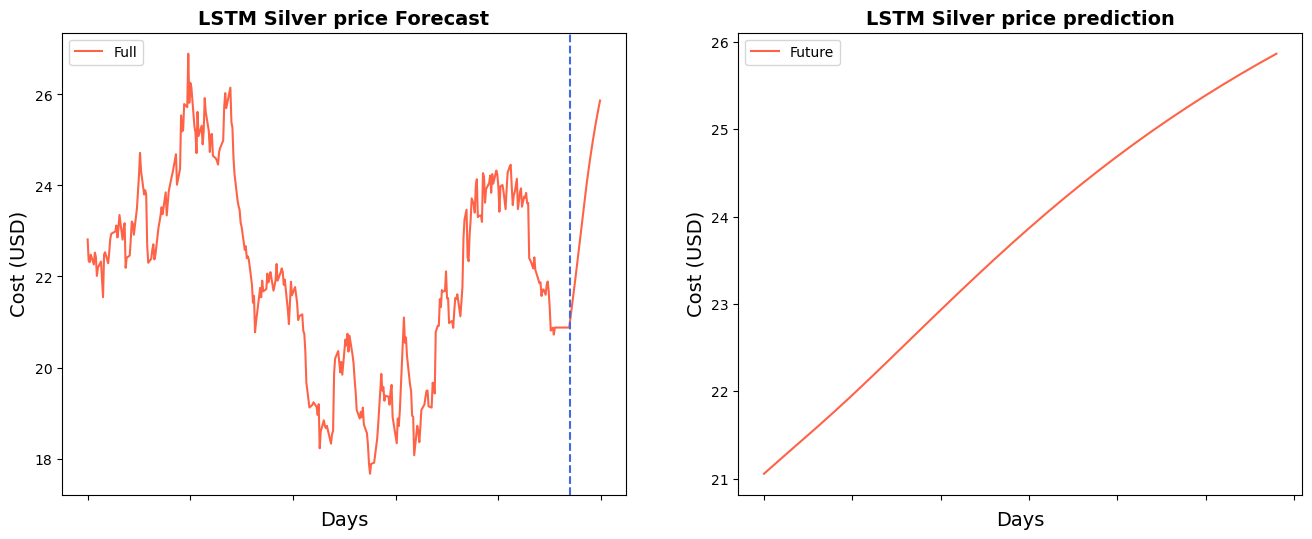

In [647]:
# The blue line separates the real data from the predicted data
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = full_data.index, y = full_data[0], label="Full", color='tomato')
ax.set_title('LSTM Silver price Forecast', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10);
ax.axvline(x=window_last_data - days_in_the_future, color='royalblue', linestyle='--')

plt.subplot(1, 2, 2)
ax = sns.lineplot(x = predicted_data.index, y = predicted_data[0], label="Future", color='tomato')
ax.set_title('LSTM Silver price prediction', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10);

fig.set_figheight(6)
fig.set_figwidth(16)

- Last day of the prediction was Feb 28 of 2023, this is the real data after that date.
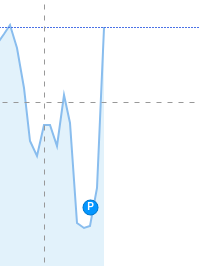
- It should go down to a bottom of \\$19.976 on 8 of march, and go up to \\$21.913 on 13 of march.